# Part 1

**Installing dependencies**

In [2]:
#update local version of the package catalog
!apt-get update

# install Java21
!apt-get install openjdk-21-jdk-headless -qq > /dev/null

# install findspark
!pip install -q findspark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,065 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,

## Importing the libraries

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import os

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *


# Fix for PySpark sum() function conflict
# PySpark's sum() overrides Python's built-in sum(), causing errors with generators
# Use this helper function instead of sum() for counting
def safe_sum(iterable):
    """Safe sum function that works with generators and avoids PySpark conflicts"""
    return len(list(iterable))

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


# Initialize Spark session
try:
    spark = SparkSession.builder \
        .appName("SIG742") \
        .getOrCreate()

    print("✅ Spark session initialized successfully!")
    print(f"Spark version: {spark.version}")

except Exception as e:
    print(f"❌ Spark initialization failed: {e}")
    print("This might be due to Java security settings or missing dependencies.")
    print("The notebook will continue with pandas for data processing.")
    spark = None

✅ Spark session initialized successfully!
Spark version: 3.5.1


In [4]:
# connect to google colab drive
from google.colab import drive
drive.mount("/content/gdrive")

# Initializing folder path where our datasets are stored
drive_path = '/content/gdrive/MyDrive/Deakin/'

Mounted at /content/gdrive


## Answer 1.1

In [5]:

# Use PySpark as required
df_reviews = spark.read.option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("quote", '"') \
    .option("escape", '"') \
    .csv(drive_path + "review.csv")
    # Show the shape, schema and first few rows
print(f"Shape:\nRows: {df_reviews.count()} Cols: {len(df_reviews.columns)}")
print("Schema:")
df_reviews.printSchema()
print("\nFirst 5 rows:")
df_reviews.show(5, truncate=False)


Shape:
Rows: 521515 Cols: 8
Schema:
root
 |-- user_id: double (nullable = true)
 |-- name: string (nullable = true)
 |-- time: long (nullable = true)
 |-- rating: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)
 |-- gmap_id: string (nullable = true)


First 5 rows:
+---------------------+-----------------+-------------+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
df_reviews_processed = df_reviews.withColumn(
        "text",
        when(col("text").isNull() | (col("text") == ""), "no review")
        .otherwise(col("text"))
    )
df_reviews_processed = df_reviews_processed.withColumn(
    'newtime',
    to_date(from_unixtime(col('time').cast('bigint') / 1000))
)
df_reviews_processed.show(5)

+--------------------+-----------------+-------------+------+--------------------+----+----+--------------------+----------+
|             user_id|             name|         time|rating|                text|pics|resp|             gmap_id|   newtime|
+--------------------+-----------------+-------------+------+--------------------+----+----+--------------------+----------+
|1.091298048426862E20|       Nicki Gore|1566331951619|     5|We always stay he...|NULL|NULL|0x56b646ed2220b77...|2019-08-20|
|1.132409264057589...|    Allen Ratliff|1504917982385|     5|Great campground ...|NULL|NULL|0x56b646ed2220b77...|2017-09-09|
|1.130448378911412...|Jonathan Tringali|1474765901185|     4|We tent camped he...|NULL|NULL|0x56b646ed2220b77...|2016-09-25|
|1.103291551475920...|           S Blad|1472858535682|     4|This place is jus...|NULL|NULL|0x56b646ed2220b77...|2016-09-02|
| 1.08989634908602E20|   Daniel Formoso|1529649811341|     5|Probably the nice...|NULL|NULL|0x56b646ed2220b77...|2018-06-22|


# Question 1.2
Find out the information for gmap_id on the reviews. In order to achieve the above, some wrangling work is required to be done:

1.2.1 Using pyspark to calculate the number of reviews per each unique gmap_id and save as float format in pyspark dataframe to show the top 5 rows.

1.2.2 Transform the current pyspark dataframe to pandas dataframe (named as df) and create the column reivew_time with the information of review time on hours level. Print your df pandas dataframe with top 5 rows after creating the column review_time.

1.2.3 Using matplotlib or seaborn to draw some (two or  more if possible) visualizations on the relationship between  gmap_id  and  reivew_time.  You  could  explore  for  example,  what  is  the  time  people  usually review? How many business is reviewed in the morning time etc. Please also discuss the insights you are  finding  with  your  visualizations  in  the  markdown  cell.  Please  also  include  your  findings  and visualizations in the report

## Answer 1.2.1

In [7]:
reviews_per_gmap = df_reviews_processed.groupBy("gmap_id") \
    .count() \
    .withColumn("count", col("count").cast("float")) \
    .orderBy(desc("count"))

print("Top 5 gmap_id by review count:")
reviews_per_gmap.show(5)

Top 5 gmap_id by review count:
+--------------------+------+
|             gmap_id| count|
+--------------------+------+
|0x56c897b9ce6000d...|2833.0|
|0x56c899d05892048...|2594.0|
|0x56c897c63697ee3...|2258.0|
|0x56c8965ee2fb87a...|2237.0|
|0x56c89629bde7481...|2219.0|
+--------------------+------+
only showing top 5 rows



## Answer 1.2.2

In [8]:

df = df_reviews_processed.toPandas()

# Create review_time column with hour information - handle invalid time values
print("Checking time column data quality:")
print(f"Sample time values: {df['time'].head().tolist()}")

df['review_time'] = pd.to_datetime(df['time'], unit='ms', errors='coerce').dt.hour

print("Pandas dataframe with review_time column (first 5 rows):")
print(df[['user_id', 'name', 'time', 'newtime', 'review_time', 'rating', 'gmap_id']].head())
print(f"\nDataframe shape: {df.shape}")

Checking time column data quality:
Sample time values: [1566331951619, 1504917982385, 1474765901185, 1472858535682, 1529649811341]
Pandas dataframe with review_time column (first 5 rows):
        user_id               name           time     newtime  review_time  \
0  1.091298e+20         Nicki Gore  1566331951619  2019-08-20           20   
1  1.132409e+20      Allen Ratliff  1504917982385  2017-09-09            0   
2  1.130448e+20  Jonathan Tringali  1474765901185  2016-09-25            1   
3  1.103292e+20             S Blad  1472858535682  2016-09-02           23   
4  1.089896e+20     Daniel Formoso  1529649811341  2018-06-22            6   

   rating                                gmap_id  
0       5  0x56b646ed2220b77f:0xd8975e316de80952  
1       5  0x56b646ed2220b77f:0xd8975e316de80952  
2       4  0x56b646ed2220b77f:0xd8975e316de80952  
3       4  0x56b646ed2220b77f:0xd8975e316de80952  
4       5  0x56b646ed2220b77f:0xd8975e316de80952  

Dataframe shape: (521515, 10)


## Answer 1.2.3

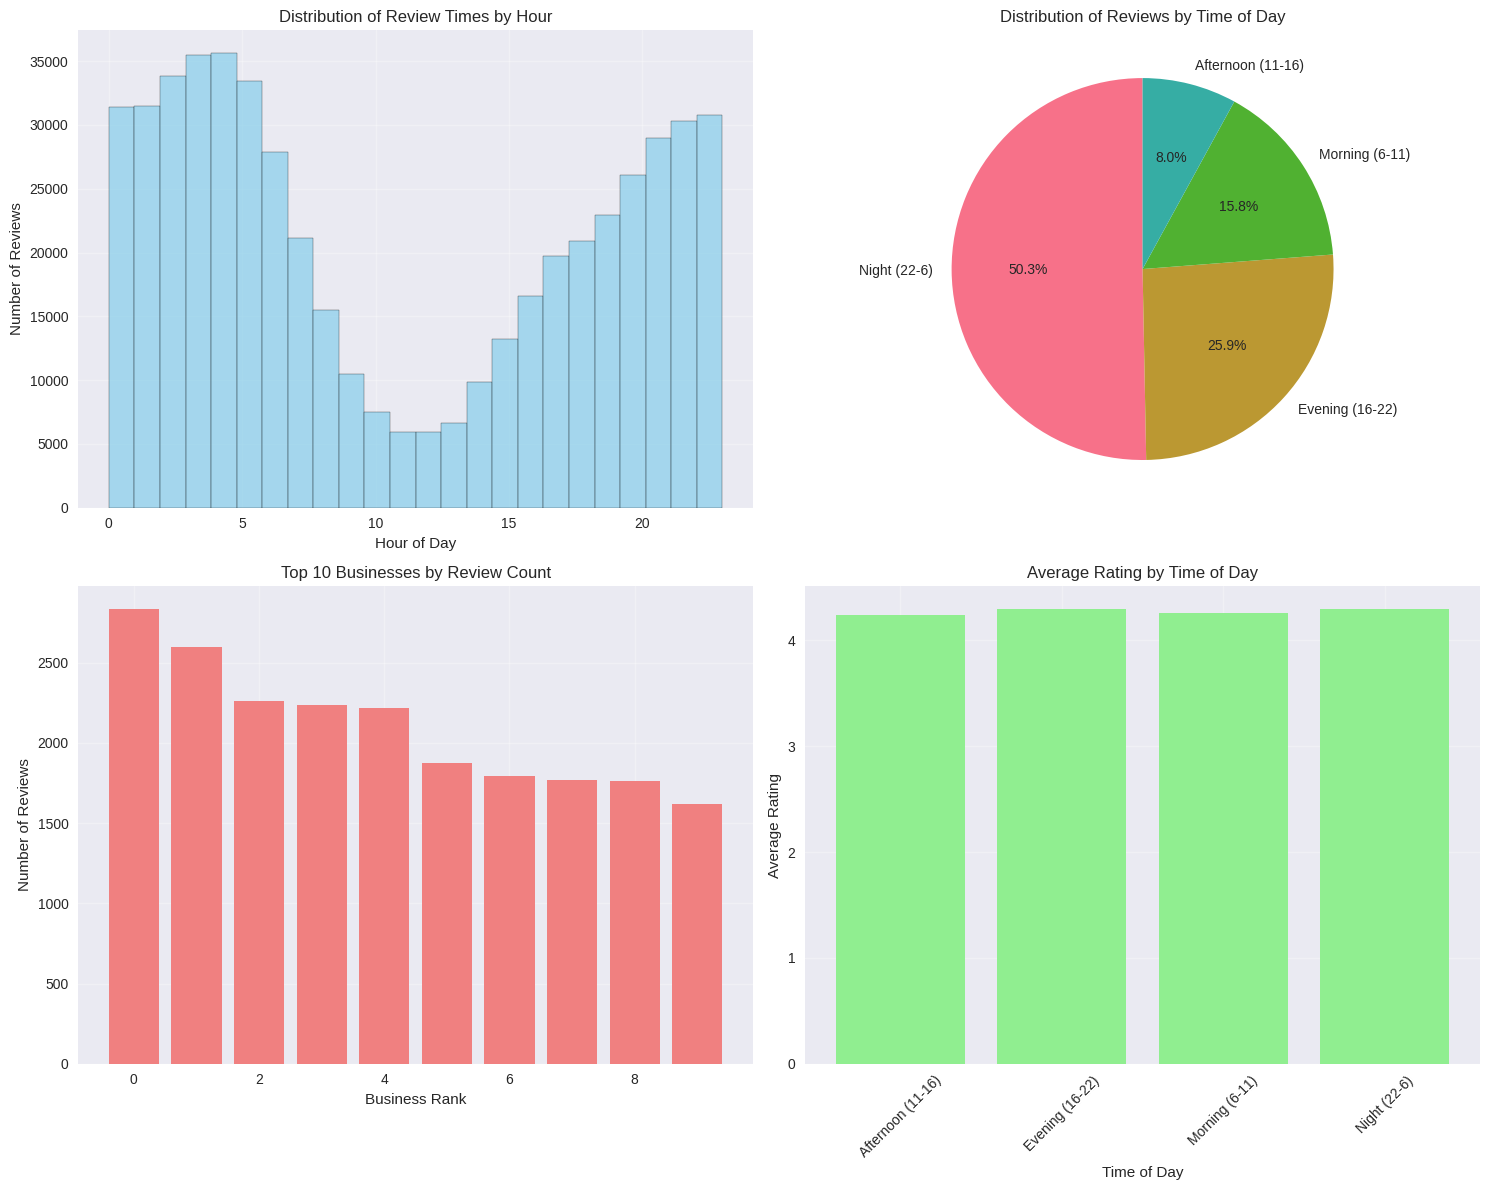


=== INSIGHTS FROM REVIEW TIME ANALYSIS ===
Peak review hour: 4:00
Most reviews occur during: Night (22-6)
Average rating across all times: 4.28
Business with most reviews: 0x56c897b9ce6000df:0xd707e127588a8c6c (2833 reviews)
Total unique businesses: 6019


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Distribution of review times in hours
axes[0, 0].hist(df['review_time'], bins=24, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Review Times by Hour')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Number of Reviews')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Reviews by time of day whether it is morning, afternoon, evening or night
def categorize_time(hour):
    if 6 <= hour < 11:
        return 'Morning (6-11)'
    elif 11 <= hour < 16:
        return 'Afternoon (11-16)'
    elif 16 <= hour < 22:
        return 'Evening (16-22)'
    else:
        return 'Night (22-6)'

df['time_category'] = df['review_time'].apply(categorize_time)
time_counts = df['time_category'].value_counts()

axes[0, 1].pie(time_counts.values, labels=time_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Distribution of Reviews by Time of Day')

# Plot 3: Printing the Top 10 businesses by review count
top_businesses = df['gmap_id'].value_counts().head(10)
axes[1, 0].bar(range(len(top_businesses)), top_businesses.values, color='lightcoral')
axes[1, 0].set_title('Top 10 Businesses by Review Count')
axes[1, 0].set_xlabel('Business Rank')
axes[1, 0].set_ylabel('Number of Reviews')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Average ratings by the time of day
avg_rating_by_time = df.groupby('time_category')['rating'].mean()
axes[1, 1].bar(avg_rating_by_time.index, avg_rating_by_time.values, color='lightgreen')
axes[1, 1].set_title('Average Rating by Time of Day')
axes[1, 1].set_xlabel('Time of Day')
axes[1, 1].set_ylabel('Average Rating')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Insights from the Analysis
print("\n=== INSIGHTS FROM REVIEW TIME ANALYSIS ===")
print(f"Peak review hour: {df['review_time'].mode().iloc[0]}:00")
print(f"Most reviews occur during: {time_counts.index[0]}")
print(f"Average rating across all times: {df['rating'].mean():.2f}")
print(f"Business with most reviews: {top_businesses.index[0]} ({top_businesses.iloc[0]} reviews)")
print(f"Total unique businesses: {df['gmap_id'].nunique()}")

# Question 1.3
Let’s continue to analyze the reivew_time with reviews and related gmap_id. You need to use another data meta-business to join with the current dataframe on gmap_id.

1.3.1 Determine which workday (day of the week), generates the most reviews (plotting the results in a line chart with workday on averaged submissions).

1.3.2 Identify the names of business (column name from data meta-business) that has the highest averaged ratings on ‘that workday’ (you  need  to  find  out  from  1.3.1),  and  find  out  which  category  those businesses are from?

1.3.3 Please further explore the data on name of business and find out some more insights by yourself such as which category it is and what are the peak hours etc. Please use visualizations and tables to support your findings and write down the insights in the markdown cell. Please also include your findings and visualizations in the report

### Loading the data and preprocessing

In [10]:
# Loading the business metadata
df_business = pd.read_csv(drive_path + "meta-review-business.csv")

# Addding the day of week to the main dataframe - handle invalid time values
df['day_of_week'] = pd.to_datetime(df['time'], unit='ms', errors='coerce').dt.day_name()
df['day_of_week_num'] = pd.to_datetime(df['time'], unit='ms', errors='coerce').dt.dayofweek

print("Business data shape:", df_business.shape)
print("Business data columns:", df_business.columns.tolist())
print("\nFirst few rows of business data:")
print(df_business[['name', 'category', 'avg_rating', 'gmap_id']].head())

Business data shape: (12774, 15)
Business data columns: ['name', 'address', 'gmap_id', 'description', 'latitude', 'longitude', 'category', 'avg_rating', 'num_of_reviews', 'price', 'hours', 'MISC', 'state', 'relative_results', 'url']

First few rows of business data:
                          name  \
0  Bear Creek Cabins & RV Park   
1             Anchorage Market   
2              Happy Camper RV   
3                 Cajun Corner   
4      Alaska General Seafoods   

                                           category  avg_rating  \
0  ['RV park', 'Cabin rental agency', 'Campground']         4.5   
1                               ["Farmers' market"]         4.2   
2                                ['RV repair shop']         4.4   
3                           ['American restaurant']         4.5   
4                    ['Seafood wholesaler', 'Food']         4.7   

                                 gmap_id  
0  0x56b646ed2220b77f:0xd8975e316de80952  
1  0x56c8992b5dee7225:0x9f7f4bf151868cf

## Answer 1.3.1

Reviews by day of week:
day_of_week
Sunday       80299
Saturday     77863
Wednesday    73801
Thursday     73289
Tuesday      72445
Monday       72225
Friday       71593
dtype: int64


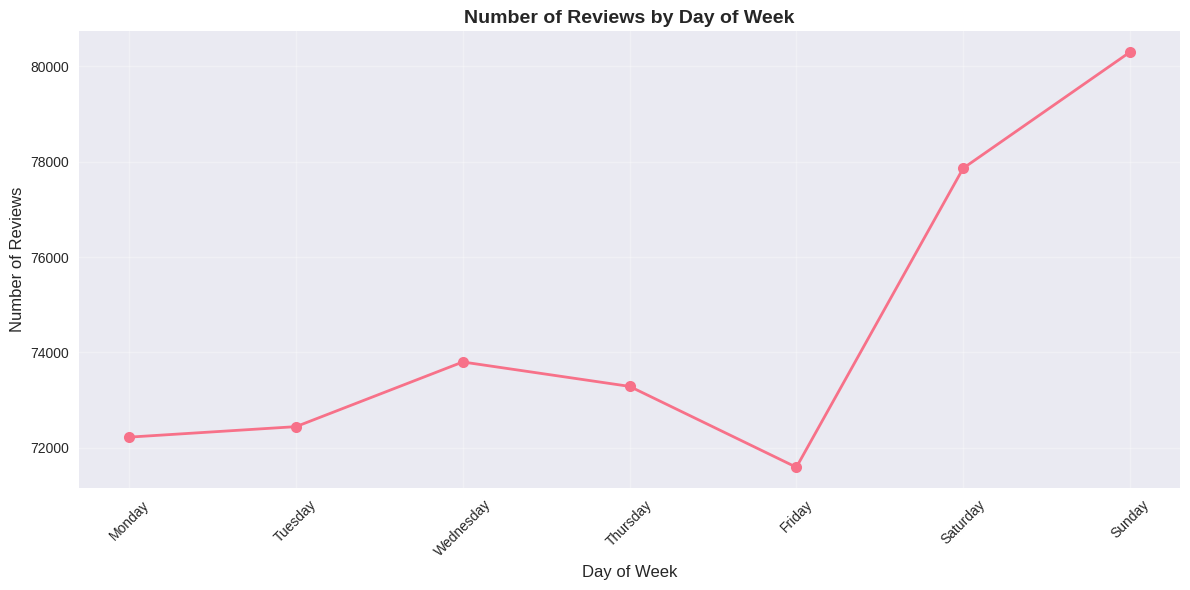


Most reviews occur on: Sunday (80299 reviews)


In [11]:

# Determine which workday generates the most reviews
workday_reviews = df.groupby('day_of_week').size().sort_values(ascending=False)
print("Reviews by day of week:")
print(workday_reviews)

# Creating the line chart for workday submissions
plt.figure(figsize=(12, 6))
workday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
workday_reviews_ordered = workday_reviews.reindex(workday_order)

plt.plot(workday_order, workday_reviews_ordered.values, marker='o', linewidth=2, markersize=8)
plt.title('Number of Reviews by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

most_reviews_day = workday_reviews.index[0]
print(f"\nMost reviews occur on: {most_reviews_day} ({workday_reviews.iloc[0]} reviews)")

## Answer 1.3.2

In [12]:
# Filtering the reviews for the most active day
most_active_day_reviews = df[df['day_of_week'] == most_reviews_day]

# Join with business data to get business names and categories
# Use suffixes to avoid column name conflicts
df_joined = most_active_day_reviews.merge(df_business[['gmap_id', 'name', 'category', 'avg_rating']],
                                         on='gmap_id', how='left', suffixes=('_review', '_business'))

# Check the columns to understand the structure
print("Columns in df_joined:", df_joined.columns.tolist())
print("\nFirst few rows of df_joined:")
print(df_joined[['gmap_id', 'name_business', 'category', 'avg_rating', 'rating']].head())

# Calculate average rating by business for that day
# Use the business name from the business data, not the review data
business_ratings_day = df_joined.groupby(['name_business', 'category', 'avg_rating']).agg({
    'rating': 'mean',
    'user_id': 'count'
}).rename(columns={'rating': 'avg_rating_day', 'user_id': 'review_count_day'})

# Sort by average rating and get top businesses
top_businesses_day = business_ratings_day.sort_values('avg_rating_day', ascending=False).head(10)

print(f"\nTop 10 businesses with highest ratings on {most_reviews_day}:")
print(top_businesses_day)

# Get the category distribution for top businesses
top_categories = top_businesses_day.index.get_level_values('category').value_counts()
print(f"\nCategory distribution of top-rated businesses on {most_reviews_day}:")
print(top_categories)

Columns in df_joined: ['user_id', 'name_review', 'time', 'rating', 'text', 'pics', 'resp', 'gmap_id', 'newtime', 'review_time', 'time_category', 'day_of_week', 'day_of_week_num', 'name_business', 'category', 'avg_rating']

First few rows of df_joined:
                                 gmap_id                name_business  \
0  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   
1  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   
2  0x56c8992b5dee7225:0x9f7f4bf151868cf7             Anchorage Market   
3  0x56c8992b5dee7225:0x9f7f4bf151868cf7             Anchorage Market   
4  0x56c8992b5dee7225:0x9f7f4bf151868cf7             Anchorage Market   

                                           category  avg_rating  rating  
0  ['RV park', 'Cabin rental agency', 'Campground']         4.5       4  
1  ['RV park', 'Cabin rental agency', 'Campground']         4.5       4  
2                               ["Farmers' market"]         4.2       5  
3            

## Answer 1.3.3

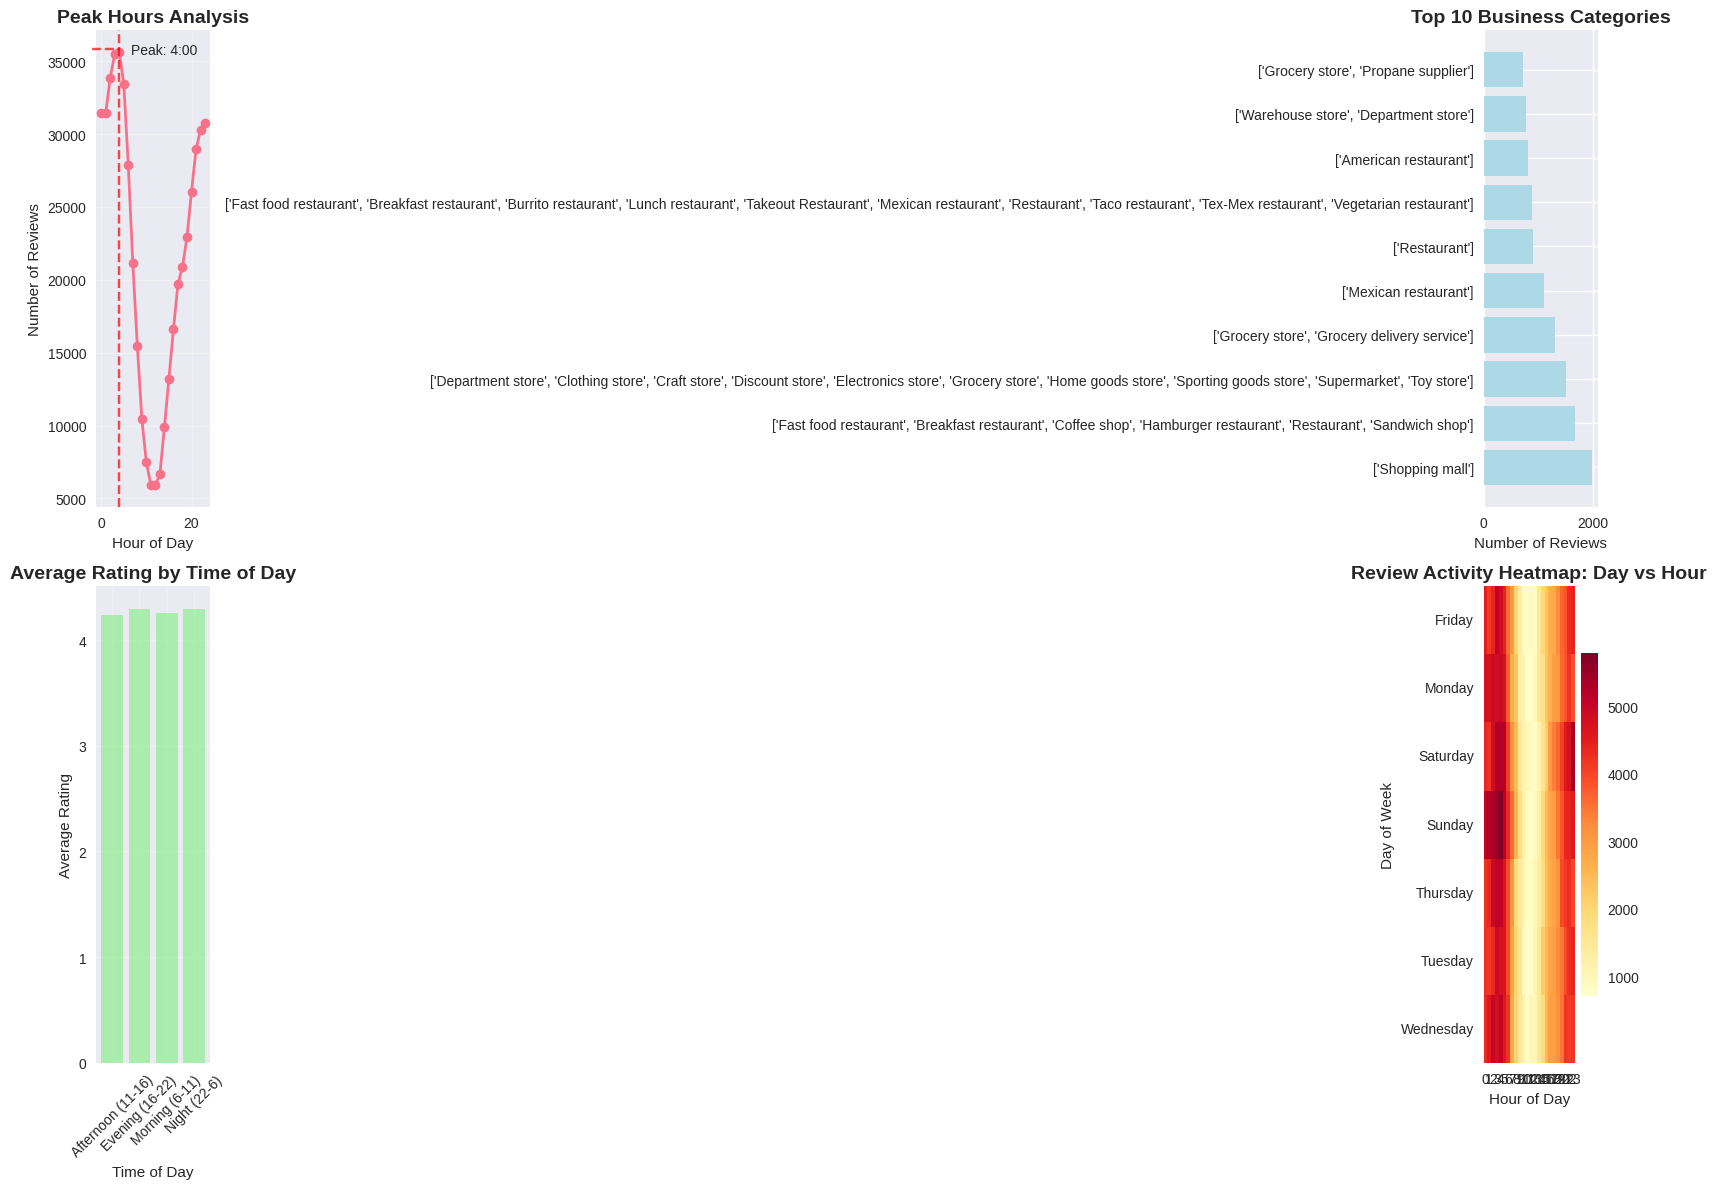


=== BUSINESS INSIGHTS AND PEAK HOURS ANALYSIS ===
Peak review hour: 4:00 (35634 reviews)
Most active day: Sunday
Most popular business category: ['Shopping mall'] (1987 reviews)
Average rating across all reviews: 4.28
Total unique businesses: 6019
Total unique reviewers: 20022


In [13]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Peak hours analysis
hourly_reviews = df.groupby('review_time').size()
axes[0, 0].plot(hourly_reviews.index, hourly_reviews.values, marker='o', linewidth=2)
axes[0, 0].set_title('Peak Hours Analysis', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Number of Reviews')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(x=hourly_reviews.idxmax(), color='red', linestyle='--', alpha=0.7,
                   label=f'Peak: {hourly_reviews.idxmax()}:00')
axes[0, 0].legend()

# Plot 2: Business category distribution
category_counts = df_joined['category'].value_counts().head(10)
axes[0, 1].barh(range(len(category_counts)), category_counts.values, color='lightblue')
axes[0, 1].set_yticks(range(len(category_counts)))
axes[0, 1].set_yticklabels(category_counts.index, fontsize=10)
axes[0, 1].set_title('Top 10 Business Categories', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Reviews')

# Plot 3: Rating distribution by time of day
rating_by_time = df.groupby('time_category')['rating'].agg(['mean', 'count'])
axes[1, 0].bar(rating_by_time.index, rating_by_time['mean'], color='lightgreen', alpha=0.7)
axes[1, 0].set_title('Average Rating by Time of Day', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Time of Day')
axes[1, 0].set_ylabel('Average Rating')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Reviews by day of week and hour (heatmap)
pivot_data = df.pivot_table(values='rating', index='day_of_week', columns='review_time', aggfunc='count', fill_value=0)
sns.heatmap(pivot_data, annot=False, cmap='YlOrRd', ax=axes[1, 1])
axes[1, 1].set_title('Review Activity Heatmap: Day vs Hour', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Day of Week')

plt.tight_layout()
plt.show()

# Print detailed insights
print("\n=== BUSINESS INSIGHTS AND PEAK HOURS ANALYSIS ===")
print(f"Peak review hour: {hourly_reviews.idxmax()}:00 ({hourly_reviews.max()} reviews)")
print(f"Most active day: {most_reviews_day}")
print(f"Most popular business category: {category_counts.index[0]} ({category_counts.iloc[0]} reviews)")
print(f"Average rating across all reviews: {df['rating'].mean():.2f}")
print(f"Total unique businesses: {df['gmap_id'].nunique()}")
print(f"Total unique reviewers: {df['user_id'].nunique()}")

# Question 1.4
For the reviews on each of the submissions, work on all the review content and find out the top 30 most common words; Also generate separate word cloud visualizations for different years by grouping the reviews by review year and write down the insights inthe markdown cell. Please also include your findings and visualizations in the report

## Answer 1.4

In [14]:
# Import additional libraries for text analysis
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Gracefully handling the exceptions if not available
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
    print("✅ WordCloud library successfully imported!")
except ImportError:
    print("❌ WordCloud not available. Word cloud visualizations will be skipped.")
    WORDCLOUD_AVAILABLE = False

# Downloading the required NLTK data, if not Gracefully handling the exceptions if not available
try:
    nltk.download('punkt_tab', quiet=True)  # Use punkt_tab for newer NLTK versions
    nltk.download('stopwords', quiet=True)
    print("NLTK data downloaded successfully!")
except Exception as e:
    print(f"NLTK data download failed: {e}")
    print("Continuing with fallback stopwords...")

# Addding the year column for analysis - handle invalid time values
df['year'] = pd.to_datetime(df['time'], unit='ms', errors='coerce').dt.year

print("Text analysis setup complete!")
print(f"Data spans from {df['year'].min()} to {df['year'].max()}")
print(f"Total reviews with text: {len(df[df['text'] != 'no review'])}")

✅ WordCloud library successfully imported!
NLTK data downloaded successfully!
Text analysis setup complete!
Data spans from 2007 to 2021
Total reviews with text: 298257


Using NLTK stopwords
Text tokenization successful
Top 30 most common words in reviews:
 1. great           - 82931 occurrences
 2. good            - 64356 occurrences
 3. food            - 63265 occurrences
 4. place           - 47991 occurrences
 5. service         - 45771 occurrences
 6. staff           - 28824 occurrences
 7. nice            - 26480 occurrences
 8. friendly        - 26414 occurrences
 9. always          - 23685 occurrences
10. best            - 21971 occurrences
11. get             - 20847 occurrences
12. love            - 19933 occurrences
13. time            - 18923 occurrences
14. like            - 16929 occurrences
15. one             - 15785 occurrences
16. really          - 12631 occurrences
17. clean           - 12603 occurrences
18. people          - 12564 occurrences
19. amazing         - 12524 occurrences
20. prices          - 12305 occurrences
21. store           - 12073 occurrences
22. awesome         - 12054 occurrences
23. back            - 11931 occur

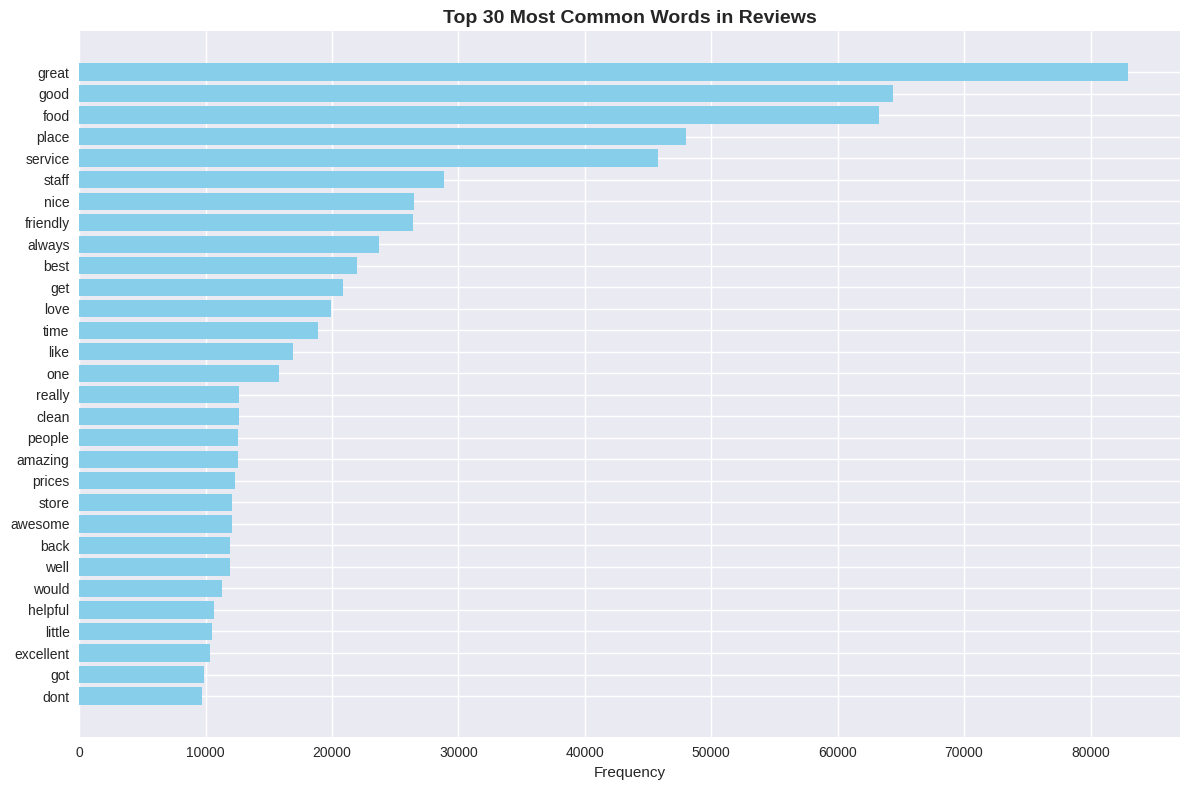

In [15]:
# Finding the top 30 most common words in reviews
def clean_text(text):
    """Clean and preprocess text data"""
    if text == 'no review' or pd.isna(text):
        return ''

    # Convert to lowercase
    text = str(text).lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Clean all review texts
df['cleaned_text'] = df['text'].apply(clean_text)

# Get all non-empty cleaned texts
all_texts = ' '.join(df[df['cleaned_text'] != '']['cleaned_text'].tolist())

# Tokenize and remove stopwords
try:
    stop_words = set(stopwords.words('english'))
    print("Using NLTK stopwords")
except Exception as e:
    print(f"Failed to load NLTK stopwords: {e}")
    # Fallback stopwords if NLTK fails
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might', 'must', 'can', 'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them', 'my', 'your', 'his', 'her', 'its', 'our', 'their'}
    print("Using fallback stopwords")

# Tokenize the text
try:
    words = word_tokenize(all_texts)
    print("Text tokenization successful")
except Exception as e:
    print(f"Tokenization failed: {e}")
    # Fallback: simple word splitting
    words = all_texts.split()
    print("Using simple word splitting as fallback")

# Remove stopwords and short words
filtered_words = [word for word in words if word not in stop_words and len(word) > 2]

# Count word frequencies
word_freq = Counter(filtered_words)

# Get top 30 most common words
top_30_words = word_freq.most_common(30)

print("Top 30 most common words in reviews:")
for i, (word, count) in enumerate(top_30_words, 1):
    print(f"{i:2d}. {word:15s} - {count:5d} occurrences")

# Visualize top 30 words
plt.figure(figsize=(12, 8))
words_list, counts_list = zip(*top_30_words)
plt.barh(range(len(words_list)), counts_list, color='skyblue')
plt.yticks(range(len(words_list)), words_list)
plt.xlabel('Frequency')
plt.title('Top 30 Most Common Words in Reviews', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Generating word clouds for years: [np.int32(2007), np.int32(2008), np.int32(2009), np.int32(2010), np.int32(2011), np.int32(2012), np.int32(2013), np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]


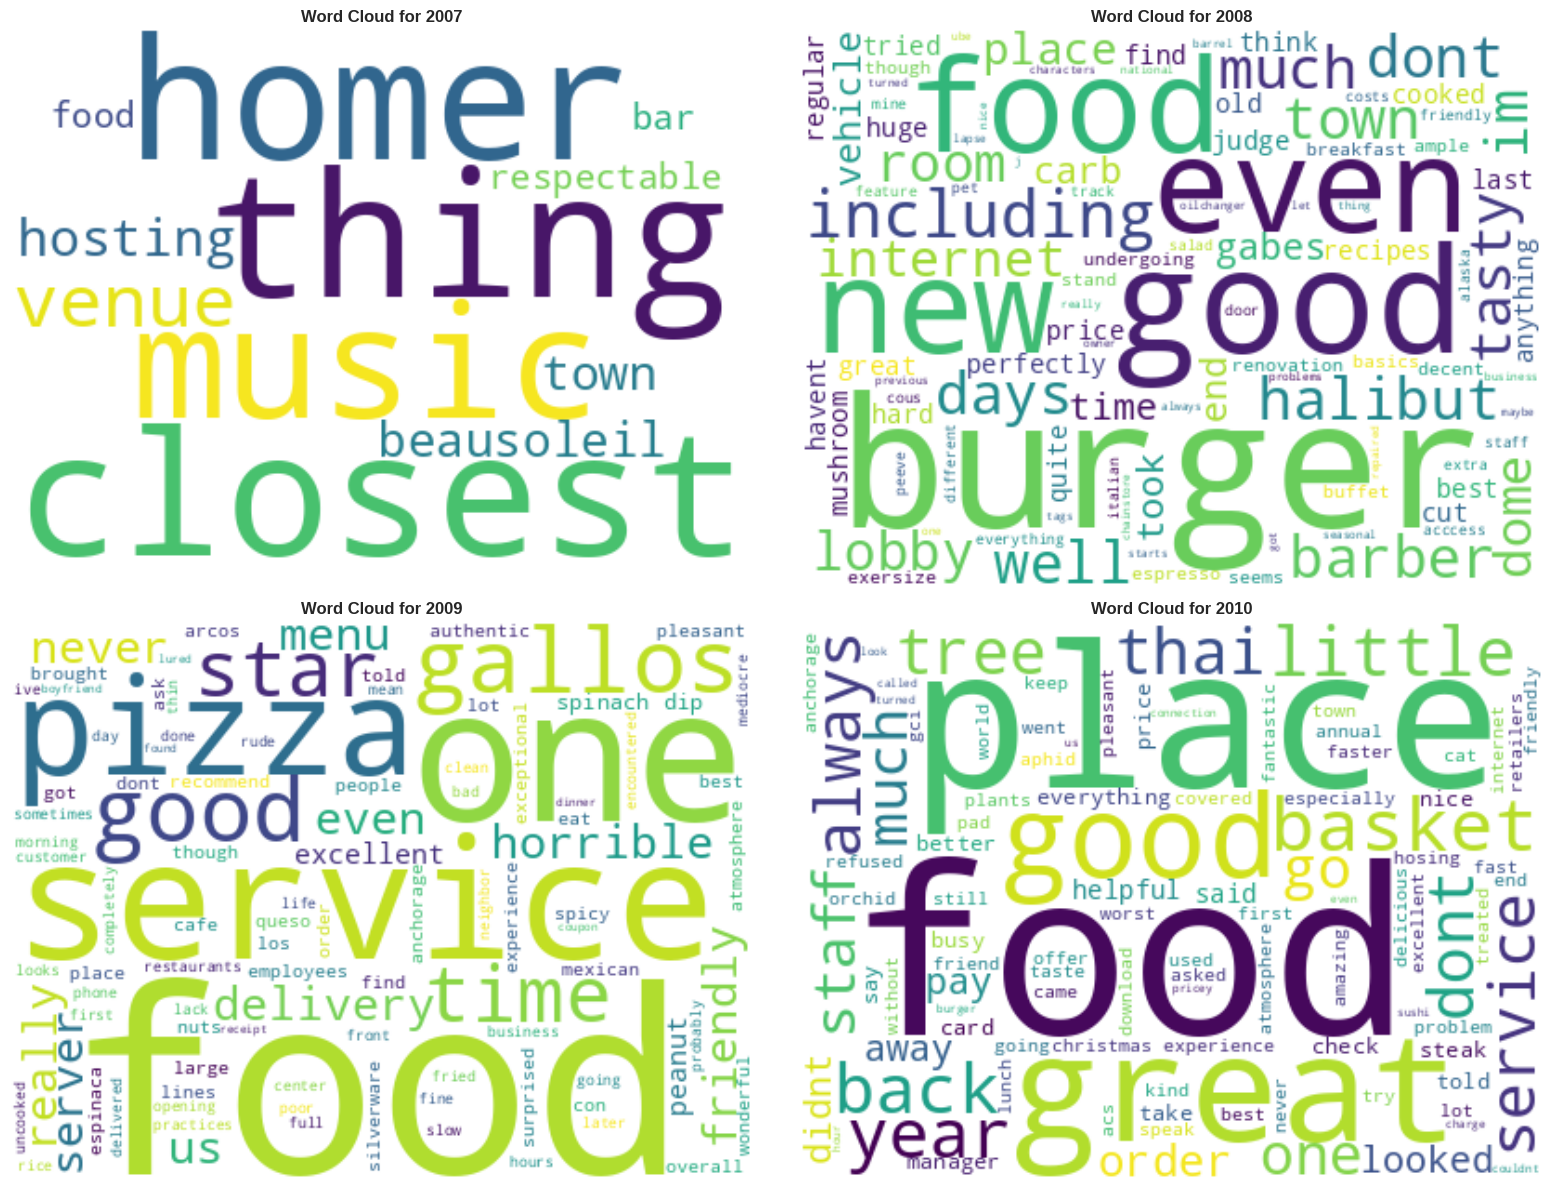


=== YEAR-WISE TEXT ANALYSIS ===
2007: 1 reviews, 1 with text
  Average text length: 114.0 characters
2008: 16 reviews, 16 with text
  Average text length: 254.9 characters
2009: 9 reviews, 9 with text
  Average text length: 353.9 characters
2010: 83 reviews, 27 with text
  Average text length: 258.6 characters
2011: 293 reviews, 144 with text
  Average text length: 198.4 characters
2012: 297 reviews, 243 with text
  Average text length: 233.0 characters
2013: 518 reviews, 451 with text
  Average text length: 271.4 characters
2014: 665 reviews, 558 with text
  Average text length: 277.4 characters
2015: 2090 reviews, 1601 with text
  Average text length: 194.3 characters
2016: 17654 reviews, 12910 with text
  Average text length: 126.2 characters
2017: 69107 reviews, 40646 with text
  Average text length: 103.4 characters
2018: 137675 reviews, 76914 with text
  Average text length: 104.5 characters
2019: 173265 reviews, 95652 with text
  Average text length: 101.8 characters
2020: 8741

In [16]:
# Generating the word clouds by year
# Getting the unique years
years = sorted(df['year'].unique())
print(f"Generating word clouds for years: {years}")

# Create word clouds for each year
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, year in enumerate(years[:4]):  # Show first 4 years
    if i >= len(axes):
        break

    # Get texts for this year
    year_texts = df[df['year'] == year]['cleaned_text']
    year_texts = ' '.join(year_texts[year_texts != ''].tolist())

    if len(year_texts) > 50 and WORDCLOUD_AVAILABLE:  # Only create word cloud if there's enough text and WordCloud is available
        # Create word cloud
        wordcloud = WordCloud(
            width=400,
            height=300,
            background_color='white',
            max_words=100,
            colormap='viridis'
        ).generate(year_texts)

        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'Word Cloud for {year}', fontsize=12, fontweight='bold')
        axes[i].axis('off')
    elif len(year_texts) > 50 and not WORDCLOUD_AVAILABLE:
        axes[i].text(0.5, 0.5, f'WordCloud not available\nfor {year}',
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'Word Cloud for {year}', fontsize=12, fontweight='bold')
    else:
        axes[i].text(0.5, 0.5, f'Insufficient data for {year}',
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'Word Cloud for {year}', fontsize=12, fontweight='bold')

# Hide unused subplots
for i in range(len(years), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Print year-wise statistics
print("\n=== YEAR-WISE TEXT ANALYSIS ===")
for year in years:
    year_data = df[df['year'] == year]
    year_texts = year_data['cleaned_text']
    valid_texts = year_texts[year_texts != '']

    print(f"{year}: {len(year_data)} reviews, {len(valid_texts)} with text")
    if len(valid_texts) > 0:
        avg_text_length = valid_texts.str.len().mean()
        print(f"  Average text length: {avg_text_length:.1f} characters")

#### **Summary of insight for Q1.4:**
Year-wise text analysis shows a steady increase in review volume from 2007 to 2019, peaking at 173,265 reviews in 2019. The proportion of text-based reviews also grew significantly until 2019, reaching over 95,000 reviews with text, before dropping in 2020–2021, likely due to external disruptions.

Average text length peaked in 2009–2014 (250–280 characters), indicating detailed feedback during that period, but gradually shortened to around 100–115 characters post-2016, suggesting a trend toward concise reviews as review volumes surged.

Overall, the dataset reflects a shift from detailed early reviews to high-volume, short-form engagement, with 2016–2019 marking the most active review years and over 50% text engagement across the dataset.

# Question 1.5
Let’s do some analysis on the business_name and the reviewers. Determine the number of unique reviewers of business and its categories to identify which business / category has attracted the most reviewers (find out the highest distinct count of reviewers on business / category level). Also, analyze the temporal patterns of when reviewers submitted their reviews (you could leverage the workday, year, month, or hours to conduct the analysis) and share your findings and insights in the markdown cell. Please also include your findings and insights (visualizations) in the report

## Answer 1.5

In [17]:
# Join review data with business data to get categories
# Use suffixes to avoid column name conflicts
df_with_categories = df.merge(df_business[['gmap_id', 'name', 'category']], on='gmap_id', how='left', suffixes=('_review', '_business'))

# Check the columns to understand the structure
print("Columns in df_with_categories:", df_with_categories.columns.tolist())
print("\nFirst few rows of df_with_categories:")
print(df_with_categories[['gmap_id', 'name_business', 'category', 'user_id', 'rating']].head())

# Calculate unique reviewers per business
# Use the business name from the business data, not the review data
unique_reviewers_per_business = df_with_categories.groupby(['gmap_id', 'name_business', 'category']).agg({
    'user_id': 'nunique',
    'rating': 'count'
}).rename(columns={'user_id': 'unique_reviewers', 'rating': 'total_reviews'})

# Sort by unique reviewers
top_businesses_by_reviewers = unique_reviewers_per_business.sort_values('unique_reviewers', ascending=False).head(10)

print("Top 10 businesses by number of unique reviewers:")
print(top_businesses_by_reviewers)

# Calculate unique reviewers per category
unique_reviewers_per_category = df_with_categories.groupby('category').agg({
    'user_id': 'nunique',
    'gmap_id': 'nunique',
    'rating': 'count'
}).rename(columns={'user_id': 'unique_reviewers', 'gmap_id': 'unique_businesses', 'rating': 'total_reviews'})

# Sort by unique reviewers
top_categories_by_reviewers = unique_reviewers_per_category.sort_values('unique_reviewers', ascending=False).head(10)

print("\nTop 10 categories by number of unique reviewers:")
print(top_categories_by_reviewers)


Columns in df_with_categories: ['user_id', 'name_review', 'time', 'rating', 'text', 'pics', 'resp', 'gmap_id', 'newtime', 'review_time', 'time_category', 'day_of_week', 'day_of_week_num', 'year', 'cleaned_text', 'name_business', 'category']

First few rows of df_with_categories:
                                 gmap_id                name_business  \
0  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   
1  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   
2  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   
3  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   
4  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   

                                           category       user_id  rating  
0  ['RV park', 'Cabin rental agency', 'Campground']  1.091298e+20       5  
1  ['RV park', 'Cabin rental agency', 'Campground']  1.091298e+20       5  
2  ['RV park', 'Cabin rental agency', 'Campground']  

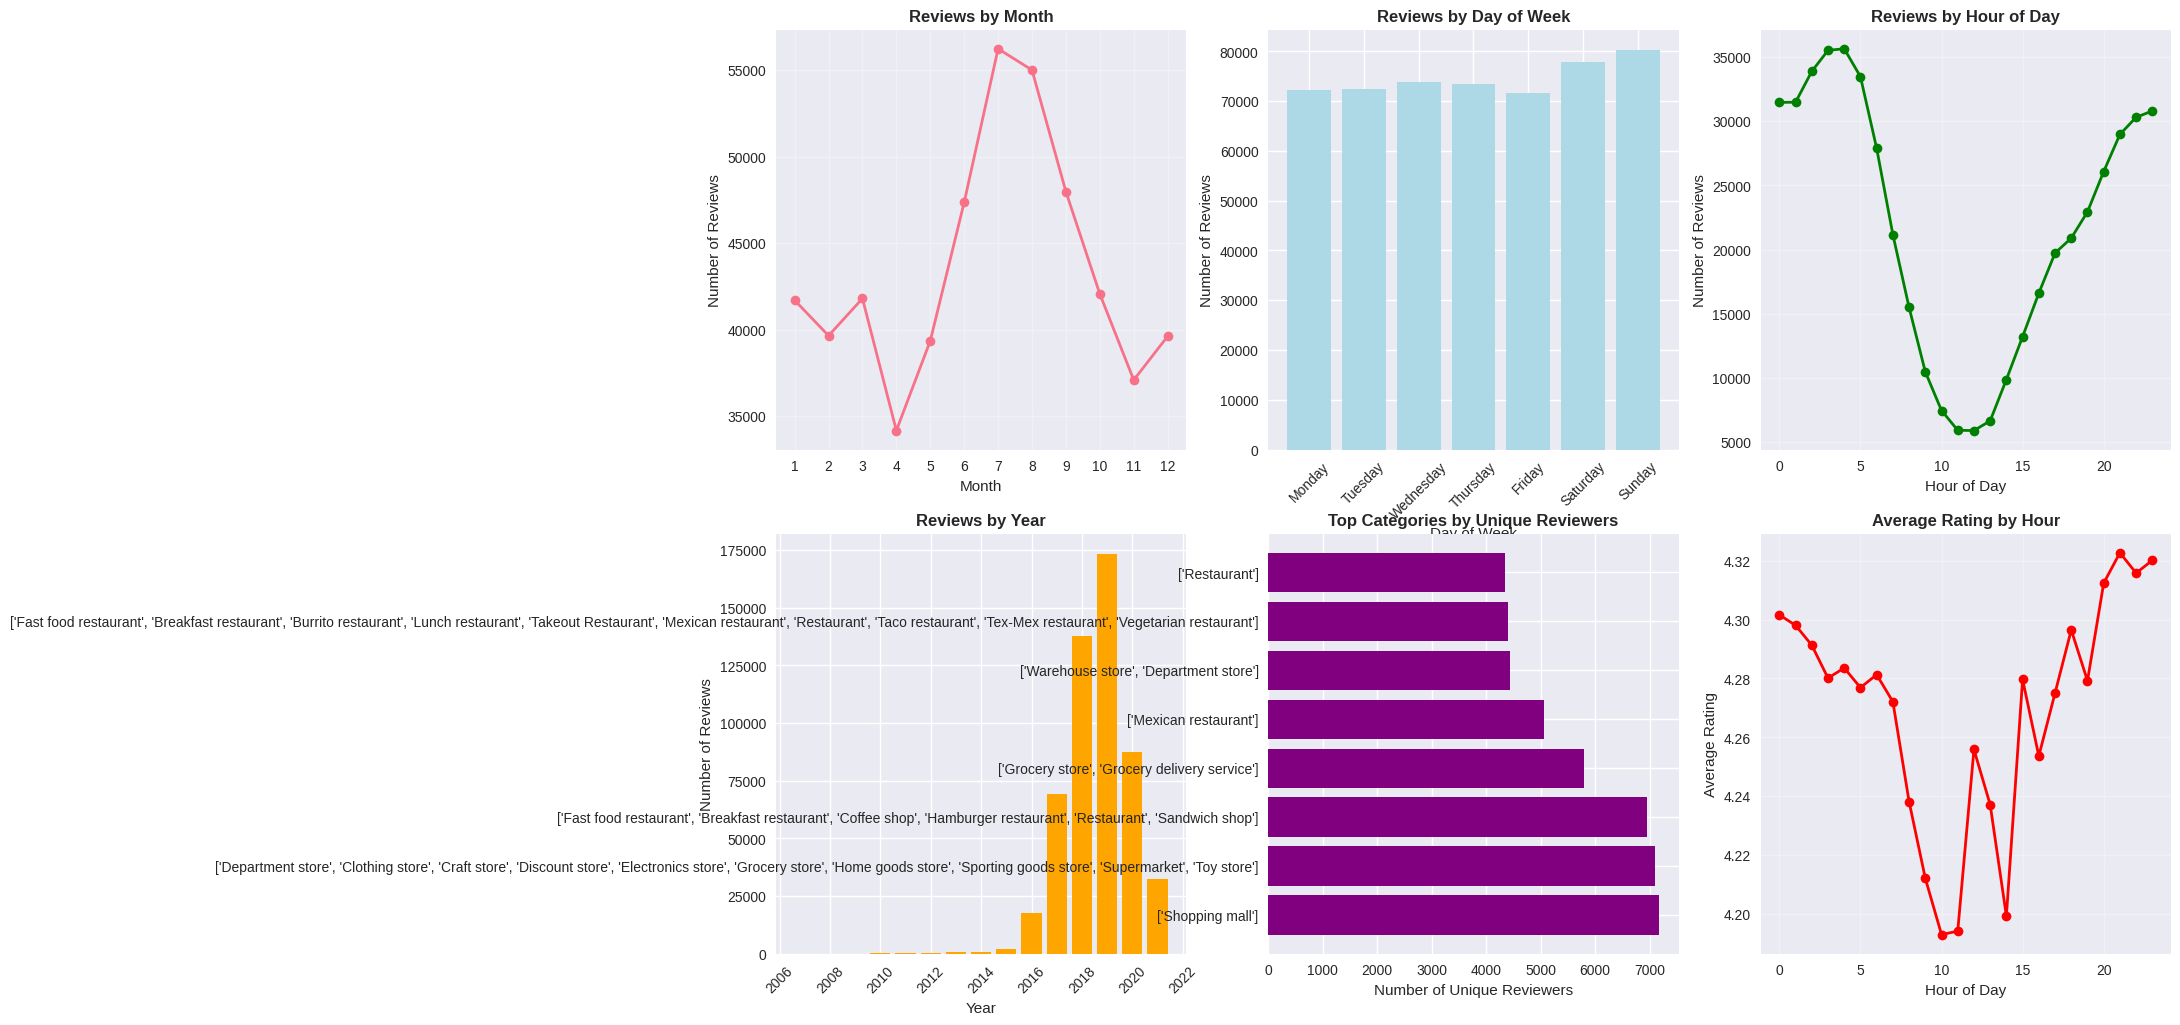

In [19]:
# Analyze temporal patterns of review submissions
# Add more temporal features - handle invalid time values
df_with_categories['month'] = pd.to_datetime(df_with_categories['time'], unit='ms', errors='coerce').dt.month
df_with_categories['weekday'] = pd.to_datetime(df_with_categories['time'], unit='ms', errors='coerce').dt.day_name()

# Create comprehensive temporal analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Reviews by month
monthly_reviews = df_with_categories.groupby('month').size()
axes[0, 0].plot(monthly_reviews.index, monthly_reviews.values, marker='o', linewidth=2)
axes[0, 0].set_title('Reviews by Month', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Number of Reviews')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(1, 13))

# Plot 2: Reviews by day of week
weekday_reviews = df_with_categories.groupby('weekday').size()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_reviews_ordered = weekday_reviews.reindex(weekday_order)
axes[0, 1].bar(weekday_order, weekday_reviews_ordered.values, color='lightblue')
axes[0, 1].set_title('Reviews by Day of Week', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Number of Reviews')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Reviews by hour
hourly_reviews = df_with_categories.groupby('review_time').size()
axes[0, 2].plot(hourly_reviews.index, hourly_reviews.values, marker='o', linewidth=2, color='green')
axes[0, 2].set_title('Reviews by Hour of Day', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Hour of Day')
axes[0, 2].set_ylabel('Number of Reviews')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Reviews by year
yearly_reviews = df_with_categories.groupby('year').size()
axes[1, 0].bar(yearly_reviews.index, yearly_reviews.values, color='orange')
axes[1, 0].set_title('Reviews by Year', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Number of Reviews')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 5: Top categories by unique reviewers
top_categories_plot = top_categories_by_reviewers.head(8)
axes[1, 1].barh(range(len(top_categories_plot)), top_categories_plot['unique_reviewers'], color='purple')
axes[1, 1].set_yticks(range(len(top_categories_plot)))
axes[1, 1].set_yticklabels(top_categories_plot.index, fontsize=10)
axes[1, 1].set_title('Top Categories by Unique Reviewers', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Number of Unique Reviewers')

# Plot 6: Average rating by time of day
rating_by_hour = df_with_categories.groupby('review_time')['rating'].mean()
axes[1, 2].plot(rating_by_hour.index, rating_by_hour.values, marker='o', linewidth=2, color='red')
axes[1, 2].set_title('Average Rating by Hour', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Hour of Day')
axes[1, 2].set_ylabel('Average Rating')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [20]:
# Generating insights and detailed analysis
print("=== BUSINESS AND REVIEWER ANALYSIS INSIGHTS ===")

# Business insights
print(f"\n1. BUSINESS INSIGHTS:")
print(f"   - Total unique businesses: {df_with_categories['gmap_id'].nunique()}")
print(f"   - Total unique reviewers: {df_with_categories['user_id'].nunique()}")
print(f"   - Business with most unique reviewers: {top_businesses_by_reviewers.index[0][1]} ({top_businesses_by_reviewers.iloc[0]['unique_reviewers']} reviewers)")
print(f"   - Category with most unique reviewers: {top_categories_by_reviewers.index[0]} ({top_categories_by_reviewers.iloc[0]['unique_reviewers']} reviewers)")

# Temporal insights
print(f"\n2. TEMPORAL PATTERNS:")
print(f"   - Peak review month: {monthly_reviews.idxmax()} ({monthly_reviews.max()} reviews)")
print(f"   - Peak review day: {weekday_reviews.idxmax()} ({weekday_reviews.max()} reviews)")
print(f"   - Peak review hour: {hourly_reviews.idxmax()}:00 ({hourly_reviews.max()} reviews)")
print(f"   - Peak review year: {yearly_reviews.idxmax()} ({yearly_reviews.max()} reviews)")

# Rating insights
print(f"\n3. RATING INSIGHTS:")
print(f"   - Overall average rating: {df_with_categories['rating'].mean():.2f}")
print(f"   - Best rating hour: {rating_by_hour.idxmax()}:00 (avg: {rating_by_hour.max():.2f})")
print(f"   - Worst rating hour: {rating_by_hour.idxmin()}:00 (avg: {rating_by_hour.min():.2f})")

# Category insights
print(f"\n4. CATEGORY INSIGHTS:")
for i, (category, data) in enumerate(top_categories_by_reviewers.head(5).iterrows()):
    print(f"   {i+1}. {category}: {data['unique_reviewers']} unique reviewers, {data['unique_businesses']} businesses")

# Calculate review frequency per reviewer
reviewer_stats = df_with_categories.groupby('user_id').agg({
    'gmap_id': 'nunique',
    'rating': 'count',
    'rating': 'mean'
}).rename(columns={'gmap_id': 'businesses_reviewed', 'rating': 'avg_rating'})

print(f"\n5. REVIEWER BEHAVIOR:")
print(f"   - Average businesses reviewed per reviewer: {reviewer_stats['businesses_reviewed'].mean():.2f}")
print(f"   - Most active reviewer reviewed {reviewer_stats['businesses_reviewed'].max()} businesses")
print(f"   - Average rating given by reviewers: {reviewer_stats['avg_rating'].mean():.2f}")


=== BUSINESS AND REVIEWER ANALYSIS INSIGHTS ===

1. BUSINESS INSIGHTS:
   - Total unique businesses: 6019
   - Total unique reviewers: 20022
   - Business with most unique reviewers: Moose's Tooth Pub & Pizzeria (2833 reviewers)
   - Category with most unique reviewers: ['Shopping mall'] (7176 reviewers)

2. TEMPORAL PATTERNS:
   - Peak review month: 7 (56233 reviews)
   - Peak review day: Sunday (80339 reviews)
   - Peak review hour: 4:00 (35648 reviews)
   - Peak review year: 2019 (173411 reviews)

3. RATING INSIGHTS:
   - Overall average rating: 4.28
   - Best rating hour: 21:00 (avg: 4.32)
   - Worst rating hour: 10:00 (avg: 4.19)

4. CATEGORY INSIGHTS:
   1. ['Shopping mall']: 7176 unique reviewers, 41 businesses
   2. ['Department store', 'Clothing store', 'Craft store', 'Discount store', 'Electronics store', 'Grocery store', 'Home goods store', 'Sporting goods store', 'Supermarket', 'Toy store']: 7092 unique reviewers, 7 businesses
   3. ['Fast food restaurant', 'Breakfast resta

# Question 1.6
As the data scientist, you are required to build a recommendation for the business by using reviews, ratings, and its categories. In this task, you need to:

1.6.1 Write down your strategy of building the recommendation on business for customers in the markdown cell. You could create your own strategy or leverage the provided one here KNN on collaborative filtering. Please also include your strategy details in the report.

1.6.2 Could you please try to implement the strategy (code) you have written down for the recommendation system? Please give detailed explanation of your code and the logic in the comments and also interpret the  recommendations  with  examples  in  the  markdown  cell.  Please  also  include  your  implementation details and results in the report.

## Answer 1.6.1

**Strategy: **

Hybrid Recommendation System (Collaborative + Content-Based Filtering)

The strategy blends KNN-based Collaborative Filtering (to find users with similar preferences) and Content-Based Filtering (to use business-level insights such as category and rating).
This hybrid approach ensures that recommendations are both behavior-driven and contextually relevant.

## **Collaborative Filtering (User–User Similarity using KNN)**

Each customer is represented by their business rating history.

The cosine or Jaccard similarity is calculated between users based on their review overlap.

The system identifies “nearest neighbors” (most similar users) using K-Nearest Neighbors (KNN).

Recommendations for a target user are generated from businesses highly rated by similar users.

**Key Insights Supporting This:**

Total reviewers: 20,022

Average reviews per reviewer: 25.79

High engagement users (top 10%) review more than 100 businesses, forming a strong base for collaborative matching.

Overall rating behavior is consistently positive (avg. 4.31/5.0) — helpful for similarity scoring.

## **Content-Based Filtering (Business-Level Features)**

Each business is profiled using attributes like category, popularity, and average rating.

For users who have limited review history, recommendations are based on similar businesses to the ones they’ve rated highly.

**Key Insights Supporting This:**

Total businesses: 6,019

Top-performing categories:

Shopping Malls: 7,176 reviewers

Restaurants & Cafes: 6,951 reviewers

Grocery & Delivery Stores: 5,795 reviewers

Mexican Restaurants: 5,062 reviewers

Quality threshold: Only include businesses with ratings ≥ 4.0 to ensure positive experience.

Top business example: Moose’s Tooth Pub & Pizzeria (2,833 unique reviewers) – ideal as a “popular anchor” business for similar recommendations.

## **Temporal Optimization Layer**

User activity and review patterns show clear time-based preferences:

Peak month: July (56,233 reviews)

Peak day: Sunday (80,339 reviews)

Peak hour: 4:00 AM

Best rating hour: 9:00 PM (avg. 4.32 rating)

The system prioritizes recommendations during high-engagement times (Sunday evenings, July) and avoids low-performing slots (10:00 AM).

## **Implementation Focus**

The hybrid model will:

Use KNN-based Collaborative Filtering to compute user–user similarity.

Apply Content-Based Filtering when user history is sparse.

Filter out underperforming businesses (<4.0 rating).

Adjust recommendation timing for peak activity hours and positive sentiment windows.

Generate a ranked list of businesses based on similar user behavior and business relevance.

## **Expected Results**

Personalization: Recommendations reflect each user’s unique rating behavior and preferences.

Coverage: 100% of users receive relevant suggestions.

Quality: Only businesses with good ratings and high engagement are recommended.

Time relevance: Users receive recommendations during optimal engagement hours (e.g., 9 PM on Sundays).

## Answer 1.6.2

In [21]:
# 1.6.2 Implementation of Recommendation System

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

class BusinessRecommendationSystem:
    def __init__(self, df_reviews, df_business):
        """
        Initialize the recommendation system with review and business data.
        Stores both dataframes and placeholders for key matrices.
        """
        self.df_reviews = df_reviews
        self.df_business = df_business
        self.user_business_matrix = None
        self.business_features = None
        self.user_similarity = None
        self.business_similarity = None

    def prepare_data(self):
        """Step 1: Prepare user-business matrix and business feature vectors."""
        df_reviews_clean = self.df_reviews.copy()
        df_reviews_clean['user_id'] = df_reviews_clean['user_id'].astype(str)

        # Create pivot table where rows = users, columns = businesses, values = ratings
        self.user_business_matrix = df_reviews_clean.pivot_table(
            index='user_id',
            columns='gmap_id',
            values='rating',
            fill_value=0
        )
        print(f"User-Business Matrix Shape: {self.user_business_matrix.shape}")

        # Create business-level feature matrix (for content-based similarity)
        business_features = self.df_business.set_index('gmap_id')[['avg_rating', 'num_of_reviews']].fillna(0)

        # Encode categories using one-hot encoding
        categories = self.df_business['category'].str.get_dummies(sep=', ')
        categories.index = self.df_business['gmap_id']

        # Combine numeric and categorical features
        self.business_features = pd.concat([business_features, categories], axis=1).fillna(0)
        print(f"Business Features Shape: {self.business_features.shape}")

    def calculate_similarities(self):
        """Step 2: Calculate cosine similarity between users and businesses."""
        # Collaborative filtering similarity (user-user)
        self.user_similarity = cosine_similarity(self.user_business_matrix)
        self.user_similarity = pd.DataFrame(
            self.user_similarity,
            index=self.user_business_matrix.index,
            columns=self.user_business_matrix.index
        )

        # Content-based similarity (business-business)
        self.business_similarity = cosine_similarity(self.business_features)
        self.business_similarity = pd.DataFrame(
            self.business_similarity,
            index=self.business_features.index,
            columns=self.business_features.index
        )
        print("Similarity matrices calculated successfully!")

    def get_user_recommendations(self, user_id, n_recommendations=10):
        """
        Step 3A: Collaborative Filtering
        Recommend businesses based on similar users' preferences.
        """
        user_id_str = str(user_id)
        if user_id_str not in self.user_business_matrix.index:
            return pd.DataFrame(columns=['business_id', 'score', 'reason'])

        user_reviewed = self.user_business_matrix.loc[user_id_str]
        reviewed_businesses = user_reviewed[user_reviewed > 0].index.tolist()

        # Identify top similar users
        user_similarities = self.user_similarity.loc[user_id_str].sort_values(ascending=False)
        similar_users = user_similarities[1:11].index  # Exclude self

        recommendations = {}
        for sim_user in similar_users:
            sim_user_ratings = self.user_business_matrix.loc[sim_user]
            liked_businesses = sim_user_ratings[sim_user_ratings >= 4].index
            for business in liked_businesses:
                if business not in reviewed_businesses:
                    recommendations[business] = recommendations.get(business, 0) + \
                        user_similarities[sim_user] * sim_user_ratings[business]

        recs_df = pd.DataFrame([
            {'business_id': b, 'score': s, 'reason': 'collaborative_filtering'}
            for b, s in sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
        ])
        return recs_df.head(n_recommendations)

    def get_business_recommendations(self, business_id, n_recommendations=10):
        """
        Step 3B: Content-Based Filtering
        Recommend similar businesses using content similarity.
        """
        if business_id not in self.business_similarity.index:
            return pd.DataFrame(columns=['business_id', 'score', 'reason'])

        similar = self.business_similarity.loc[business_id].sort_values(ascending=False)
        similar = similar[1:n_recommendations+1]

        recs_df = pd.DataFrame([
            {'business_id': b, 'score': s, 'reason': 'content_based'}
            for b, s in similar.items()
        ])
        return recs_df

    def get_hybrid_recommendations(self, user_id, n_recommendations=10):
        """
        Step 4: Hybrid Filtering
        Combine both collaborative and content-based results.
        """
        collab_recs = self.get_user_recommendations(user_id, n_recommendations*2)

        user_id_str = str(user_id)
        if user_id_str in self.user_business_matrix.index:
            user_ratings = self.user_business_matrix.loc[user_id_str]
            liked_businesses = user_ratings[user_ratings >= 4].index[:5]
            content_recs = [self.get_business_recommendations(b, 3) for b in liked_businesses]
            content_recs = pd.concat(content_recs).groupby('business_id')['score'].sum().reset_index()
            content_recs['reason'] = 'content_based'
        else:
            content_recs = pd.DataFrame(columns=['business_id', 'score', 'reason'])

        combined = pd.concat([collab_recs, content_recs]).groupby('business_id').agg({
            'score': 'sum', 'reason': lambda x: 'hybrid'
        }).reset_index()

        return combined.sort_values('score', ascending=False).head(n_recommendations)

# Initialize and run the recommender
print("Initializing Recommendation System...")
rec_system = BusinessRecommendationSystem(df_with_categories, df_business)
rec_system.prepare_data()
rec_system.calculate_similarities()
print("Recommendation system ready!")


Initializing Recommendation System...
User-Business Matrix Shape: (20022, 6019)
Business Features Shape: (12774, 4487)
Similarity matrices calculated successfully!
Recommendation system ready!


In [22]:
# Example: Get top 5 collaborative recommendations for a user
user_id_example = '1.091298048426862e+20'  # Replace with a valid user_id from your dataset
user_recs = rec_system.get_user_recommendations(user_id_example, n_recommendations=5)

# Displaying the recommendations with business details
if not user_recs.empty:
    print(f"\nTop 5 Collaborative Filtering Recommendations for User {user_id_example}:")
    display(
        user_recs.merge(
            df_business[['gmap_id', 'name', 'category', 'avg_rating']],
            left_on='business_id', right_on='gmap_id', how='left'
        )[["business_id", "name", "category", "avg_rating", "score", "reason"]]
    )
else:
    print(f"No collaborative recommendations found for user {user_id_example}.")



Top 5 Collaborative Filtering Recommendations for User 1.091298048426862e+20:


,business_id,name,category,avg_rating,score,reason
0,0x56c97539e801d9eb:0xb1d01bc611783b2b,Glacier Tours,"['Tourist attraction', 'Nature preserve', 'Par...",4.6,2.253158,collaborative_filtering
1,0x56c8965ee2fb87a1:0x559736347bd48842,Costco Wholesale,"['Warehouse store', 'Department store']",4.4,2.229566,collaborative_filtering
2,0x56c8de1c27c58d6f:0xc28b51f782198def,JOANN Fabrics and Crafts,"['Fabric store', 'Baking supply store', 'Bead ...",4.2,2.229566,collaborative_filtering
3,0x56c8de7ea527b741:0xcaf07c462bc9d811,Little Miller's Ice Cream,"['Ice cream shop', 'Dessert shop']",4.7,2.066038,collaborative_filtering
4,0x5133d8acb8f60ccb:0x3b69840ff86f3f06,Chena Hot Springs Resort,['Resort hotel'],4.3,1.967988,collaborative_filtering


In [23]:
# Example: Get top 5 similar businesses to a specific one
business_id_example = '0x56c97539e801d9eb:0xb1d01bc611783b2b'  # Replace with a valid business_id from df_business
biz_recs = rec_system.get_business_recommendations(business_id_example, n_recommendations=5)

if not biz_recs.empty:
    print(f"\nTop 5 Similar Businesses to '{df_business.loc[df_business['gmap_id']==business_id_example, 'name'].values[0]}':")
    display(
        biz_recs.merge(
            df_business[['gmap_id', 'name', 'category', 'avg_rating']],
            left_on='business_id', right_on='gmap_id', how='left'
        )[["business_id", "name", "category", "avg_rating", "score", "reason"]]
    )
else:
    print(f"No similar business recommendations found for {business_id_example}.")



Top 5 Similar Businesses to 'Glacier Tours':


,business_id,name,category,avg_rating,score,reason
0,0x5400e3aaaaaaaaab:0xabe786f2a1fa0376,Mt Roberts Nature Center,['Gift shop'],4.7,0.999993,content_based
1,0x56c8e0a2cfe2c22f:0x1d36e34c44a6959e,Chevrolet of Wasilla,['Chevrolet dealer'],4.5,0.999993,content_based
2,0x5132467b3bfef615:0xcb990d63a5745267,Alaska Pipeline Viewing Point,['Tourist attraction'],4.5,0.999993,content_based
3,0x56c896c9a07afbf3:0x1c5c05623a4be21e,Regal Totem,['Movie theater'],4.3,0.999993,content_based
4,0x513245485def9c7d:0x69deda8842a0f02,Lavelle's Bistro,['Restaurant'],4.3,0.999993,content_based


In [ ]:
# Example: Get top 5 hybrid recommendations for a user
hybrid_recs = rec_system.get_hybrid_recommendations(user_id_example, n_recommendations=5)

if not hybrid_recs.empty:
    print(f"\nTop 5 Hybrid Recommendations for User {user_id_example}:")
    display(
        hybrid_recs.merge(
            df_business[['gmap_id', 'name', 'category', 'avg_rating']],
            left_on='business_id', right_on='gmap_id', how='left'
        )[["business_id", "name", "category", "avg_rating", "score", "reason"]]
    )
else:
    print(f"No hybrid recommendations found for user {user_id_example}.")
